# <img src="../images/sberbank.png">
# <center> Финальное задание </center>
## <center> Предсказание пола клиента по транзакциям</center>

## Описание задачи 
### В рамках финального задания будет необходимо предсказывать пол клиента, основываясь на его транзакционных исторических данных. Выполнение финального задания - это маленький шаг в большую Data Science-всесенную, поэтому отнеситесь к нему максимально серьёзно :)
### Вы будете строить предиктивные модели и отправлять результаты своего моделирования на платформу [Kaggle](https://www.kaggle.com/t/e8a939488d274dab9051cce14d5ca952), где и будет оцениваться каждое решение и положение участников. Но переживать не стоит - код, связанный с построением модели мы уже написали, поэтому вашим основным заданием будет создание новых переменных для генерации новых инсайдов из данных, которые смогут улучшить полученные значения метрики.
### В роли метрики выступает [ROC AUC](https://dyakonov.org/2017/07/28/auc-roc-%D0%BF%D0%BB%D0%BE%D1%89%D0%B0%D0%B4%D1%8C-%D0%BF%D0%BE%D0%B4-%D0%BA%D1%80%D0%B8%D0%B2%D0%BE%D0%B9-%D0%BE%D1%88%D0%B8%D0%B1%D0%BE%D0%BA/), который и нужно будет оптимизировать.

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import re
import matplotlib.pyplot as plt

from tqdm._tqdm_notebook import tqdm_notebook
from warnings import filterwarnings

%matplotlib inline
filterwarnings('ignore')

<ipython-input-1-5f5f1a276f68>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


In [2]:
# Считываем данные
tr_mcc_codes = pd.read_csv('data/tr_mcc_codes.csv', sep=';', index_col='mcc_code')
tr_types = pd.read_csv('data/tr_types.csv', sep=';', index_col='tr_type')

transactions = pd.read_csv('data/transactions.csv', index_col='customer_id')
gender_train = pd.read_csv('data/gender_train.csv', index_col='customer_id')
gender_test = pd.read_csv('data/gender_test.csv', index_col='customer_id')
transactions_train = transactions.join(gender_train, how='inner')
transactions_test = transactions.join(gender_test, how='inner')
transactions_test['mcc_code_and_tr_type'] = transactions_test['mcc_code'].astype(str) + transactions_test['tr_type'].astype(str)
transactions_train['mcc_code_and_tr_type'] = transactions_train['mcc_code'].astype(str) + transactions_train['tr_type'].astype(str)

del transactions

In [3]:
# Функции, которыми можно пользоваться для построения классификатора, 
# оценки его результатов и построение прогноза для тестовой части пользователей

# Cross-validation score (среднее значение метрики ROC AUC на тренировочных данных)
def cv_score(params, train, y_true):
    cv_res=xgb.cv(params, xgb.DMatrix(train, y_true),
                  early_stopping_rounds=10, maximize=True, 
                  num_boost_round=10000, nfold=5, stratified=True)
    index_argmax = cv_res['test-auc-mean'].argmax()
    print('Cross-validation, ROC AUC: {:.3f}+-{:.3f}, Trees: {}'.format(cv_res.loc[index_argmax]['test-auc-mean'],
                                                                        cv_res.loc[index_argmax]['test-auc-std'],
                                                                        index_argmax))

# Построение модели + возврат результатов классификации тестовых пользователей
def fit_predict(params, num_trees, train, test, target):
    params['learning_rate'] = params['eta']
    clf = xgb.train(params, xgb.DMatrix(train.values, target, feature_names=list(train.columns)), 
                    num_boost_round=num_trees, maximize=True)
    y_pred = clf.predict(xgb.DMatrix(test.values, feature_names=list(train.columns)))
    submission = pd.DataFrame(index=test.index, data=y_pred, columns=['probability'])
    return clf, submission

# Отрисовка важности переменных. Важность переменной - количество разбиений выборки, 
# в которых участвует данная переменная. Чем больше - тем она, вероятно, лучше 
def draw_feature_importances(clf, top_k=10):
    plt.figure(figsize=(10, 10))
    
    importances = dict(sorted(clf.get_score().items(), key=lambda x: x[1])[-top_k:])
    y_pos = np.arange(len(importances))
    
    plt.barh(y_pos, list(importances.values()), align='center', color='green')
    plt.yticks(y_pos, importances.keys(), fontsize=12)
    plt.xticks(fontsize=12)
    plt.xlabel('Feature importance', fontsize=15)
    plt.title('Features importances, Sberbank Gender Prediction', fontsize=18)
    plt.ylim(-0.5, len(importances) - 0.5)
    plt.show()

### Так как код для оценки модели на тренировочных данных и её применения на тестовых данных уже дан, то мы будем работать над тем, чтобы создать переменные для улучшения результатов моделирования. 

### (!) В рамках данного задания Вы можете делать всё, что угодно - использовать другие алгоритмы и/или их комбинации, подбирать гиперпараметры своих моделей, отбирать переменые, etc. Мы создали шаблон для простоты и для Вашего понимания верхнеуровневого процесса разработки модели, опустив при этом большое число деталей.

## Basic features
Начнём с того, что сформируем базовые переменные по каждому пользователю. На этом этапе будем использовать стандартные агрегации, посчитанные на расходах и приходах клиента:
- минимум
- максимум
- среднее
- медиана
- среднеквадратичное отклонение
- количество

Также параметры модели выберем стандартные, запишем их в словарь params, и будем использовать для дальнейшего построения модели (не забывайте, что с этим Вы можете тоже экспериментировать).

In [25]:
params = {    
    'eta': 0.1,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    
    'gamma': 0,
    'lambda': 0,
    'alpha': 0,
    'min_child_weight': 50,
    
    'eval_metric': 'auc',
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'njobs': -1,
    'tree_method': 'approx'
}

In [5]:
tqdm_notebook.pandas(desc="Progress:")

def features_creation_basic(x): 
    features = []
    features.append(pd.Series(x[x['amount']>0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('positive_transactions_')))
    features.append(pd.Series(x[x['amount']<0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('negative_transactions_')))
 
    return pd.concat(features)

data_train = transactions_train.groupby(transactions_train.index).progress_apply(features_creation_basic)
data_test = transactions_test.groupby(transactions_test.index).progress_apply(features_creation_basic)

Progress::   0%|          | 0/8400 [00:00<?, ?it/s]

Progress::   0%|          | 0/3600 [00:00<?, ?it/s]

In [6]:
target = data_train.join(gender_train, how='inner')['gender']
cv_score(params, data_train, target)

[01:13:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { njobs } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:13:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { njobs } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:13:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { njobs } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
 

In [7]:
### Число деревьев для XGBoost имеет смысл выставлять по результатам на кросс-валидации 
clf, submission = fit_predict(params, 70, data_train, data_test, target)

[01:13:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { njobs } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




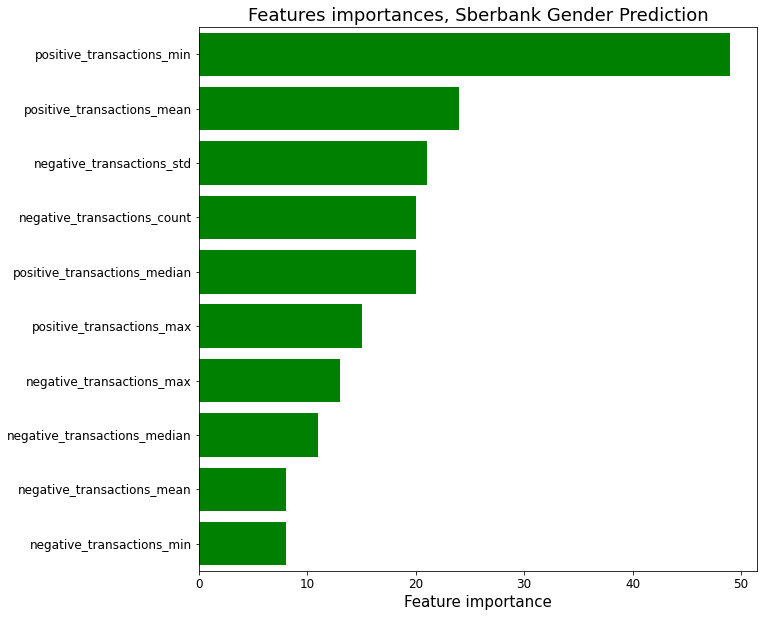

In [8]:
draw_feature_importances(clf, 10)

In [9]:
submission.to_csv('basic_features_submission.csv')

### Видим, что результат на кросс-валидации - 62.5% ROC AUC.

## Advanced features
Добавим дополнительные переменные по каждому пользователю в модель. <br>
Для этого будем анализировать дни недели, часы и состояние дня/ночи во время покупки - в каждом из случаев будем считать частоту транзакций в соответствующей категории относитеьно всех остальных категорий. <br>
То есть если, например, клиент в 70% случае совершал ночные траты, то мы получим вектор [0.7, 0.3] для этого случая в качестве частот транзакций ночью/днём.

In [10]:
for df in [transactions_train, transactions_test]:
    df['day'] = df['tr_datetime'].str.split().apply(lambda x: int(x[0]) % 7)
    df['hour'] = df['tr_datetime'].apply(lambda x: re.search(' \d*', x).group(0)).astype(int)
    df['night'] = ~df['hour'].between(6, 22).astype(int)

In [11]:
def features_creation_advanced(x): 
    features = []
    features.append(pd.Series(x['day'].value_counts(normalize=True).add_prefix('day_')))
    features.append(pd.Series(x['hour'].value_counts(normalize=True).add_prefix('hour_')))
    features.append(pd.Series(x['night'].value_counts(normalize=True).add_prefix('night_')))
    features.append(pd.Series(x[x['amount']>0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('positive_transactions_')))
    features.append(pd.Series(x[x['amount']<0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('negative_transactions_')))
    features.append(pd.Series(x['mcc_code_and_tr_type'].value_counts(normalize=True)))
 
    return pd.concat(features)

In [12]:
data_train = transactions_train.groupby(transactions_train.index)\
                               .progress_apply(features_creation_advanced).unstack(-1)
data_test = transactions_test.groupby(transactions_test.index)\
                             .progress_apply(features_creation_advanced).unstack(-1)

Progress::   0%|          | 0/8400 [00:00<?, ?it/s]

Progress::   0%|          | 0/3600 [00:00<?, ?it/s]

In [13]:
data_test.head()

,17111110,17311010,17991110,27411100,27411110,27411200,30001010,30001100,30001110,30001200,...,negative_transactions_min,negative_transactions_std,night_-1,night_-2,positive_transactions_count,positive_transactions_max,positive_transactions_mean,positive_transactions_median,positive_transactions_min,positive_transactions_std
customer_id,,,,,,,,,,,,,,,,,,,,,
6815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-224591.58,29652.262014,0.008850,0.991150,6.0,2470507.35,451092.183333,50533.105,224.59,990028.956041
27914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-462658.65,121931.651195,0.054054,0.945946,35.0,89836.63,11710.848571,5614.790,1122.96,20519.704519
31385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-364366.15,27343.958680,0.038356,0.961644,23.0,199886.50,54405.845652,41549.440,2245.92,53114.569478
38084,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1142759.68,78902.207685,0.174370,0.825630,114.0,1235253.67,231249.536316,152587.515,11229.58,232505.631983
78659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-71176.89,7827.790387,0.363636,0.636364,46.0,314428.21,32015.667174,22459.160,224.59,48517.256258


In [14]:
data_train.head()

,17111010,17111100,17111110,17311010,17311110,17991010,17991100,17991110,27411100,27411110,...,negative_transactions_min,negative_transactions_std,night_-1,night_-2,positive_transactions_count,positive_transactions_max,positive_transactions_mean,positive_transactions_median,positive_transactions_min,positive_transactions_std
customer_id,,,,,,,,,,,,,,,,,,,,,
22899,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-868607.92,102071.385485,0.085470,0.914530,68.0,875907.15,85572.397794,33688.740,88.04,1.415691e+05
28753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-3244539.76,602533.653083,0.408163,0.591837,50.0,3099363.77,914148.179400,700905.395,7860.71,8.058591e+05
42096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-337785.73,30801.769458,0.173077,0.826923,66.0,673774.73,160823.312424,112295.790,6737.75,1.233073e+05
49793,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-673774.73,164883.475699,0.077973,0.922027,25.0,112295.79,24525.401200,11229.580,1122.96,3.149071e+04
50940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-110049.87,18138.572904,0.033898,0.966102,12.0,4491.83,4491.830000,4491.830,4491.83,9.499362e-13


In [15]:
new_test = pd.DataFrame(np.zeros((3600, 1108), dtype=int))
new_test.index = data_test.index
new_test.columns = data_train.columns
new_test.head()

,17111010,17111100,17111110,17311010,17311110,17991010,17991100,17991110,27411100,27411110,...,negative_transactions_min,negative_transactions_std,night_-1,night_-2,positive_transactions_count,positive_transactions_max,positive_transactions_mean,positive_transactions_median,positive_transactions_min,positive_transactions_std
customer_id,,,,,,,,,,,,,,,,,,,,,
6815,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27914,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31385,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38084,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
78659,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
for i in data_test.columns:
    if i in data_train.columns:
        new_test[i] = data_test[i] 

In [17]:
new_test.head()

,17111010,17111100,17111110,17311010,17311110,17991010,17991100,17991110,27411100,27411110,...,negative_transactions_min,negative_transactions_std,night_-1,night_-2,positive_transactions_count,positive_transactions_max,positive_transactions_mean,positive_transactions_median,positive_transactions_min,positive_transactions_std
customer_id,,,,,,,,,,,,,,,,,,,,,
6815,0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,...,-224591.58,29652.262014,0.008850,0.991150,6.0,2470507.35,451092.183333,50533.105,224.59,990028.956041
27914,0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,...,-462658.65,121931.651195,0.054054,0.945946,35.0,89836.63,11710.848571,5614.790,1122.96,20519.704519
31385,0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,...,-364366.15,27343.958680,0.038356,0.961644,23.0,199886.50,54405.845652,41549.440,2245.92,53114.569478
38084,0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,...,-1142759.68,78902.207685,0.174370,0.825630,114.0,1235253.67,231249.536316,152587.515,11229.58,232505.631983
78659,0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,...,-71176.89,7827.790387,0.363636,0.636364,46.0,314428.21,32015.667174,22459.160,224.59,48517.256258


In [18]:
data_test.head()

,17111110,17311010,17991110,27411100,27411110,27411200,30001010,30001100,30001110,30001200,...,negative_transactions_min,negative_transactions_std,night_-1,night_-2,positive_transactions_count,positive_transactions_max,positive_transactions_mean,positive_transactions_median,positive_transactions_min,positive_transactions_std
customer_id,,,,,,,,,,,,,,,,,,,,,
6815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-224591.58,29652.262014,0.008850,0.991150,6.0,2470507.35,451092.183333,50533.105,224.59,990028.956041
27914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-462658.65,121931.651195,0.054054,0.945946,35.0,89836.63,11710.848571,5614.790,1122.96,20519.704519
31385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-364366.15,27343.958680,0.038356,0.961644,23.0,199886.50,54405.845652,41549.440,2245.92,53114.569478
38084,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1142759.68,78902.207685,0.174370,0.825630,114.0,1235253.67,231249.536316,152587.515,11229.58,232505.631983
78659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-71176.89,7827.790387,0.363636,0.636364,46.0,314428.21,32015.667174,22459.160,224.59,48517.256258


In [19]:
data_test = new_test

In [20]:
data_test

,17111010,17111100,17111110,17311010,17311110,17991010,17991100,17991110,27411100,27411110,...,negative_transactions_min,negative_transactions_std,night_-1,night_-2,positive_transactions_count,positive_transactions_max,positive_transactions_mean,positive_transactions_median,positive_transactions_min,positive_transactions_std
customer_id,,,,,,,,,,,,,,,,,,,,,
6815,0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,...,-224591.58,29652.262014,0.008850,0.991150,6.0,2470507.35,4.510922e+05,50533.105,224.59,9.900290e+05
27914,0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,...,-462658.65,121931.651195,0.054054,0.945946,35.0,89836.63,1.171085e+04,5614.790,1122.96,2.051970e+04
31385,0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,...,-364366.15,27343.958680,0.038356,0.961644,23.0,199886.50,5.440585e+04,41549.440,2245.92,5.311457e+04
38084,0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,...,-1142759.68,78902.207685,0.174370,0.825630,114.0,1235253.67,2.312495e+05,152587.515,11229.58,2.325056e+05
78659,0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,...,-71176.89,7827.790387,0.363636,0.636364,46.0,314428.21,3.201567e+04,22459.160,224.59,4.851726e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99918216,0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,...,-232452.28,28147.254414,0.303191,0.696809,5.0,256034.40,1.805716e+05,224591.580,11229.58,9.874817e+04
99938948,0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,...,-426724.00,35393.492645,0.176656,0.823344,43.0,415494.42,5.749649e+04,44918.320,2245.92,7.868836e+04
99953525,0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,...,-561478.94,63901.680451,0.186047,0.813953,16.0,224591.58,1.186124e+05,112295.790,22459.16,4.016962e+04


In [21]:
target = data_train.join(gender_train, how='inner')['gender']


[01:15:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { njobs } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:15:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { njobs } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:15:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { njobs } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
 

In [26]:
cv_score(params, data_train, target)

[01:17:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { njobs } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:17:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { njobs } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:17:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { njobs } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
 

In [27]:
### Число деревьев для XGBoost имеет смысл выятавлять по результатам на кросс-валидации 
clf, submission = fit_predict(params, 70, data_train, data_test, target)

[01:18:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { njobs } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




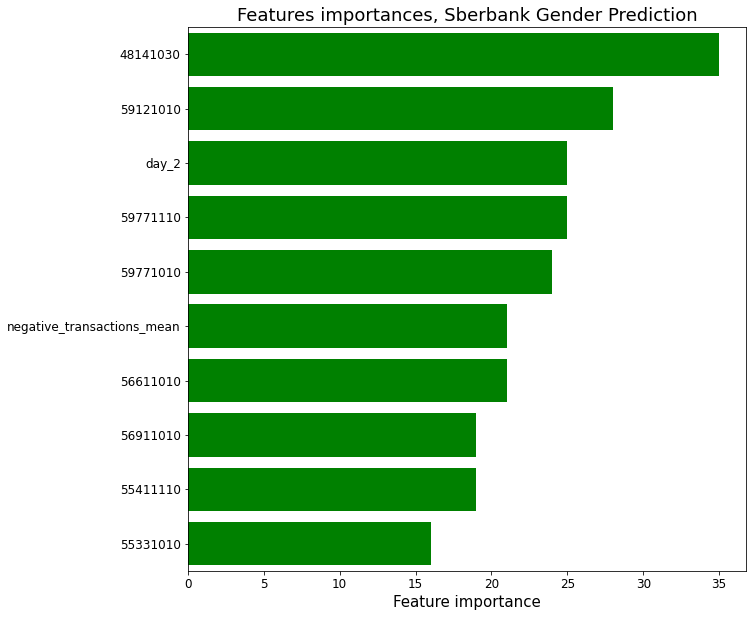

In [28]:
draw_feature_importances(clf, 10)

### Добавление новых переменных улучшило наши результаты ROC AUC с 62.5% до 68.2%, на тестовой выборке результат будет аналогичным, так что мы явно не переобучились. При этом есть куда стремиться!

### В итоге можем отправить полученное решение на платформу в Kaggle In-Class Competition. Для этого выгрузим его в *.csv - файл, после чего полученный файл можем загружать в качестве ответа.

In [29]:
submission.to_csv('submission_advanced.csv')

# (!) Цель задания:
## Полученная модель должна иметь ROC AUC на Public-части тестовой выборки (на лидерборде) не менее 80%.